## Introduction

In this project, we will implement a text-based recommendation system for movies.

The idea is that our recommendation engine provide a user with recommendations of new movies based on how similar the title of a movie the user has already watched is to the the titles of other movies in the database.

We will implement two different ways of making a movie recommendation system and one way of making a movie reranking system, based solely on the title and overview of a movie a hypothetical user might enjoy. The techniques we will employ are TF-IDF and bi-encoders. The movie reranker wil be implemented using a cross-encoder.

## Resources

- Open this page in Google Colab [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/douglasrizzo/recsys-movies/blob/master/src/text-based-movie-recs.ipynb)
- View the GitHub repo [![GitHub](https://img.shields.io/badge/github-%23121011.svg?style=for-the-badge&logo=github&logoColor=white)](https://github.com/douglasrizzo/recsys-movies/blob/master/src/text-based-movie-recs.ipynb)
- [Read the contents in my website](https://douglasrizzo.com.br/blog/2025/03/text-based-movie-recs/)

The following links instructed me on how to access a movie dataset and which libraries to use. You can check them out for more examples.

- https://www.datacamp.com/tutorial/recommender-systems-python
- https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system


## Downloading the dataset

For this exercise, we will use The Movie Database (TMDb), a dataset containing movies and their features. It does not contain user-related information, such as how many people watched a movie or movie ratings. We will use [a version provided by Kaggle user asaniczka](https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies), which is constantly updated.

To download it, we will use the Python package `kagglehub`.


In [1]:
import pathlib as pl

import kagglehub
import pandas as pd

tmdb_path = next(
  iter(pl.Path(kagglehub.dataset_download("asaniczka/tmdb-movies-dataset-2023-930k-movies")).glob("*.csv"))
)

Resuming download from 179306496 bytes (41578107 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/asaniczka/tmdb-movies-dataset-2023-930k-movies?dataset_version_number=506 (179306496/220884603) bytes left.


100%|██████████| 211M/211M [00:08<00:00, 4.74MB/s]

Extracting files...


You can see in the cells below a sample of the data we will use. At the time of this project, there were over 940,000 movies available on the dataset.

We are only interested in the title and overview of the movies, so we will drop the other columns.


In [2]:
movie_metadata = pd.read_csv(tmdb_path, index_col="id")
movie_metadata = movie_metadata.loc[~movie_metadata["overview"].isna(), ["title", "overview"]]
print(movie_metadata.shape)
movie_metadata.head()

(941184, 2)


,title,overview
id,,
27205,Inception,"Cobb, a skilled thief who commits corporate es..."
157336,Interstellar,The adventures of a group of explorers who mak...
155,The Dark Knight,Batman raises the stakes in his war on crime. ...
19995,Avatar,"In the 22nd century, a paraplegic Marine is di..."
24428,The Avengers,When an unexpected enemy emerges and threatens...


For the purposes of our project, we will only work with a sample of 10,000 movies, since the machine learning methods we will employ can be compute or memory intensive.


In [3]:
movie_metadata = movie_metadata.sample(n=10000, random_state=42).sort_index()

## Title-based recommendations using TF-IDF

The first technique we will implement is term frequency-inverse document frequency, or TF-IDF for short. It is an information retrieval technique in which a term $t_1$ inside a document $d_1$ is given a weight based on how frequently it appears in that document, compared to how frequently it appears in all other documents of our corpus. The intuitition is that:

- if $t_1$ is very common in $d_1$, it might be relevant to the context of $d_1$. This value is called the **term frequency**.
- if $t_1$ does not appear as frequently in other documents, it might be very specific to the context of $d_1$ _in particular_, so it might be very relevant. This term is called the **inverse document frequency**.

However, if $t_1$ also appears very frequently in other documents, it might not be a very informative term. Think about the word _"the"_, which may appear very frequently in a single document, but we can also find it in many other documents of a corpus.

### Term frequency

Term frequency is the relative frequency of a term within a document:

$$tf(t, d) = \frac{f(t, d)}{\sum_{t' \in d} f(t', d)}$$

Where $t$ is a term, $d$ is a document, $t'$ are the other terms in $d which are not $t$ and the function $f(t, d)$ depicts the raw number of times $t$ appears in $d$.

It can be loosely interpreted as:

$$tf(t, d) = \frac{\text{number of times } t \text{ appears in } d}{\text{sum of the number of times all other terms in } d \text{ also appear in } d}$$

### Inverse term frequency

Inverse document frequency is a measure of how informative a given term $t$ is within the corpus $D$.

If we define:

- $ \vert D \vert $ the number of documents in the corpus $D$ (the cardinality of set $D$) and
- $D' = \{d \in D:t \in d\}$ as the set of documents in $D$ that also contain term $t$

We can then compute the inverse document frequency $idf$ of a term $t$ in corpus $D$ as:

$$idf(t, D) = \log \frac{ \vert D \vert }{ \vert D' \vert }$$

Where once again $ \vert \cdot \vert $ is the notation for the cardinality of a set.

It can be interpreted as:

$$idf(t, D) = \log \frac{\text{total number of documents}}{\text{number of documents in which } t \text{ appears}}$$

The logarithm is used to balance the magnitude of the $idf$ function for terms that appear in too few document _vs_ those that appear in too many documents. You can view a chart of the $idf$ function for a term that appear in all documents $(\frac{ \vert D \vert }{ \vert D' \vert } = 1)$ all the way to a term that appears in 1% of the documents in a corpus $(\frac{ \vert D \vert }{ \vert D' \vert } = 100)$.


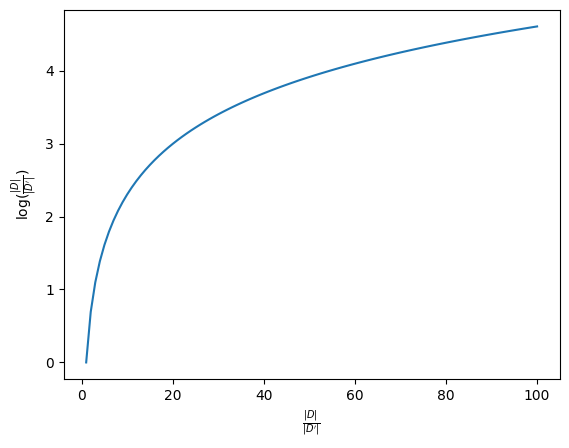

In [4]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(1, 101)
y = np.log(x)
plt.plot(x, y)
plt.xlabel("$\\frac{|D|}{|D'|}$")
plt.ylabel("$\\log(\\frac{|D|}{|D'|})$")
plt.show()

Finally, we can compute the $tfidf$ value for a term $t$ inside a document $d$ relative to a corpus $D$ as:

$$ tfidf(t, d, D) = tf(t, d) \cdot idf(t,D) $$

### Interpreting $tfidf$

- If the relative frequency of $t$ inside $d$ is high, then $tf(t, d)$ will be high
- If $t$'s frequency inside all other documents in $D$ is small, them $idf(t, D)$ will be high
- This makes $tfidf(t, d, D)$ high, meaning that the relevance of $t$ in $d$ compared to the other documents in $D$ must be high

### Implementing the recommendation engine

For this exercise, we will use scikit-learn to compute the $tfidf$ values of all words in all 10,000 titles of our movies. This will generate a $ \vert T \vert \times \vert D \vert $ matrix whose size you can see below.


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(movie_metadata["overview"])
print(tfidf_matrix.shape)

(10000, 35994)


### Computing similarities

In our example, each document $d$ is a single movie title and the corresponding vector in the tfidf matrix can be considered a numerical feature vector representing the movie title. We can compute how similar these feature vectorsamongst each other by using similarity metrics such as the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity), which we will employ below.


In [6]:
cosine_sim = (tfidf_matrix * tfidf_matrix.T).toarray()
cosine_sim.shape

(10000, 10000)

This gives us back a matrix of similarities $S$ in which $S_{x,y}$ denote how similar the titles of movies in position $x$ and $y$ are. This is a symmetric matrix $(S_{x,y} = S_{y,x})$ in which all elements in the diagonal are equal to 1 $(S_{x,x} = 1)$.

### Recovering movies with similar titles

Now, we can select a random movie from our dataset and retrieve the other movies whose titles are similar to it, according to how similar their $tfidf$ vectors are under the cosine similarity. The function below does that.


In [7]:
import operator


def get_recommendations(idx, sim_matrix):
  movie_title = movie_metadata.iloc[idx]["title"]
  print(f"Top recommendations for {movie_title}:")
  sim_scores = list(enumerate(sim_matrix[idx]))
  sim_scores = sorted(sim_scores, key=operator.itemgetter(1), reverse=True)
  sim_scores = sim_scores[1:31]
  movie_indices = [i[0] for i in sim_scores]
  return movie_metadata["title"].iloc[movie_indices]

We can see from in the results below the subset of most similar items to the one whose title is listed. You can judge for yourself whether they are actually similar, but the usefulness of a recommendation engine that searches for movies with similar titles is questionable.


In [8]:
print(get_recommendations(1, cosine_sim))

Top recommendations for Megacities:
id
164535         Trilogia - Il pensiero, lo sguardo, la parola
410067                     Pasolini and the Form of the City
516906                                      Die Republikaner
529837        Villa Air Bel. Varian Fry in Marseille 1940/41
558799                  Bella Italia - Zuflucht auf Widerruf
620839                                        Leszármazottak
1368150                                             Solitudo
1170754                 ...bis zum Bundesverfassungsgericht!
1408577                        In the Mix with Jabaar Edmond
911602                                           Window Feel
428078                                        Mortal Engines
123022                                       Whispering Hope
1144526    Bubble & Squeak murder:  The Killing of David ...
1365387    Freedom Film Series: A Higher Law: The Oberlin...
723978                                     Tierra de mujeres
646953                                        

## Movie recommendations based on sentence embeddings

In this next part of the project, we will expand our text-based recommendation engine by incorporating information about the movie overview into our similarity search.

When doing this, we face a fundamental problem: the size of our vocabulary (the set of all individual terms in all documents of our corpus) is very large, which may make computing tfidf prohibitive. Also, the feature vectors for all our moview would all be sparse as most movie overviews do not contain many words from our vocabulary.

To combat this, we can use an encoder-only transformer architecture, such as BERT and its variants, trained as a bi-encoder, to encode our arbitrarily long texts into fixed-size embeddings.

### Encoder-only transformers

These are neural network architectures whose only purpose is to transform text data into embeddings. Unlike _causal language models_ such as GPT, who are trained for next-token prediction and thus do not always have access to the full context of the text, encoder-only models (also called _masked language models_) have access to the full context of the text in order to generate its embedding.

These models can be trained for a multitude of tasks, such as text classification, sentiment analysis and even masked language modeling. After training ends, these models are able to generate fixed size text embeddings.

```mermaid
graph BT
    subgraph Causal language modeling
        direction BT
        CLM[GPT]
        You2(You) --> CLM
        must2(must) --> CLM
        construct --> CLM
        additional2(additional) --> CLM
        CLM --> pylons@{ shape: stadium }

        style CLM fill:#248315
    end

    subgraph Masked language modeling
        direction BT
        MLM[BERT]
        You1(You) --> MLM
        must1(must) --> MLM
        MASK1["<font color='red'>&ltMASK&gt</font>"] --> MLM
        additional1(additional) --> MLM
        pylons1(pylons) --> MLM
        MLM --> additional@{ shape: stadium }

        style MLM fill:#248315
    end
```

### Bi-encoders

A bi-encoder is a special kind of encoder-only transformer which is trained on labeled data, containing pairs of texts accompanied by a similarity score as in the example below.

| Sentence 1 | Sentence 2                           | Similarity |
| ---------- | ------------------------------------ | ---------- |
| I love you | I love my cat                        | 0.82       |
| I love you | You must construct additional pylons | 0.04       |

One example dataset is the Semantic Textual Similarity Benchmark (STSB). [[Hugging Face Hub]](https://huggingface.co/datasets/sentence-transformers/stsb) [[Papers with Code]](https://paperswithcode.com/dataset/sts-benchmark)

The bi-encoder is then trained in a siamese fashion so that the embeddings of texts with high similarity are also similar amongst themselves, whereas the embeddings of texts with low similarity have embeddings further away from each other. During inference, the model is individually applied to two pieces of texts and their output embeddings can be compared using cosine similarity.

```mermaid
graph TD
  subgraph Inference time
    direction BT
    AI1[Sentence A]
    AI2[BERT]
    AI3[pooling]
    AI4[u]
    BI1[Sentence B]
    BI2[BERT]
    BI3[pooling]
    BI4[v]
    CI1["cosine-sim(u,v)"]
    CI2@{ shape: stadium, label : "[-1;1]" }
    AI1 --> AI2 --> AI3 --> AI4 --> CI1
    BI1 --> BI2 --> BI3 --> BI4 --> CI1
    CI1 --> CI2
  end

  subgraph Training time
    direction BT
    AT1[Sentence A]
    AT2[Bert]
    AT3[pooling]
    AT4[u]
    BT1[Sentence B]
    BT2[Bert]
    BT3[pooling]
    BT4[v]
    CT1["(u, v, |u-v|)"]
    CT2[softmax classifier]
    AT1 --> AT2 --> AT3 --> AT4 --> CT1
    BT1 --> BT2 --> BT3 --> BT4 --> CT1
    CT1 --> CT2
  end
```

The image above is adapted from https://arxiv.org/abs/1908.10084. They mention training their bi-encoder as a classifier using cross-entropy, but do not get into details about how they do it. Other approaches include using regression to predict the cosine similarity or contrastive learning with contrastive or triplet loss in pairs of pairs of similar/dissimilar texts or triples of anchor/similar/dissimilar texts, respectively.

#### Advantages of bi-encoders

1. Embedding vector calculation is usually fast and lightweight
2. Embedding vectors for each text can be stored adfter being computed and reutilized
3. Comparison between embedding vectors is fast, using cosine similarity

### Implementing our recommendation system

For our project, we will use the [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) model, which is trained using contrastive learning on pairs of sentences.


In [9]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

The model is applied to the movie titles concatenated with their overviews and generate fixed-size embedding vectors of size 384. The output is a matrix of size $|D| \times n$, where $n$ is the dimension of the embedding vector.


In [10]:
embeddings = model.encode(
  (movie_metadata["title"] + " " + movie_metadata["overview"]).to_list(), show_progress_bar=True
)
print(embeddings.shape)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

(10000, 384)


### Recovering movies

Once again, we recover the movies that are most similar to a randomly selected one based on the similarities between their embeddings.


In [11]:
top_recommendations = get_recommendations(0, model.similarity(embeddings, embeddings))
print(top_recommendations)

Top recommendations for Billy Elliot:
id
38848                                A Few Days in September
1257034        Weatherday Live @ The Ukie Club Philly 8/7/23
372489                                                  1980
1270247                                    Bad Boy Fuck Club
11017                                          Billy Madison
18141                                  The Elementary School
472025                                      Dublin Oldschool
581089                                      Haunting Douglas
657923                      Neil Young - BBC In Concert 1971
1006663                                            1985-1986
521639                                           County Line
672083                                       The Winslow Boy
1310228                                             Identity
150518                                      Tenth Avenue Kid
192390                              The Hoosier Schoolmaster
8271                                        

### Cross-encoders

Another transformer architecture that allows us to build a text-based recommendation system is the _cross-encoder_ [[1]](https://arxiv.org/abs/1901.04085)[[2]](https://arxiv.org/abs/2101.08751). Unlike the bi-encoder, it takes a pair of sentences as input, concatenating them and separating them by a special token, and produces an output in the range $[0; 1]$ indicating how similar they are.

```mermaid
graph BT
  A(Sentence A) --> concat
  B(Sentence B) --> concat
  concat --> BERT --> Classifier --> Output@{shape: circle, label: "[0; 1]"}
```

Due to their high computational complexity and usually better results than bi-encoders, cross-encoders are usually used in the re-ranking step of recommendation systems, in which a subset of recommendations has already been selected by previous, more lightweight methods.

**Advantages of cross-encoders**

- Tend to have better results in computing sentence similarity than bi-encoders.

**Disadvantages of cross-encoders**

- Computational complexity of using cross-encoders is quadratic compared to the linear complexity of bi-encoders, as every comparison between a new piece of text and texts in storage must use the cross-encoder transformer.

### Implementing a movie reranker using a cross-encoder

The code below employs a cross-encoder to rerank the movies selected by the bi-encoder of the previous section. It returns similarity scores between the title and overview of the original movie and the pre-selected movies.


In [12]:
from sentence_transformers.cross_encoder import CrossEncoder

model = CrossEncoder("cross-encoder/stsb-roberta-base")

ranks = model.rank(
  movie_metadata.iloc[0]["title"] + " " + movie_metadata.iloc[0]["overview"],
  top_recommendations,
  show_progress_bar=True,
)
ranks = {rank["corpus_id"]: rank["score"] for rank in ranks}
print(pd.Series(ranks))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2     0.365634
26    0.360351
24    0.293843
10    0.291097
12    0.258833
9     0.257831
22    0.247428
4     0.222584
21    0.219410
5     0.211042
19    0.175163
14    0.175003
20    0.174640
27    0.173403
11    0.148287
23    0.146889
0     0.146843
13    0.145361
29    0.145283
1     0.124511
16    0.117132
25    0.108611
6     0.101460
3     0.099316
18    0.097358
17    0.080527
7     0.064563
8     0.062674
28    0.051764
15    0.049922
dtype: float32


Finally, we produce the list of reranked movies.


In [13]:
ranks_idx_sorted = sorted(zip(ranks.keys(), ranks.values(), strict=False), key=operator.itemgetter(1), reverse=True)
ranks_idx_sorted = [r[0] for r in ranks_idx_sorted]
top_recommendations.iloc[ranks_idx_sorted]

id
372489                                                  1980
463249                                     Say! Young Fellow
1373646                                                Grown
521639                                           County Line
1310228                                             Identity
1006663                                            1985-1986
228944                                Billy Childish Is Dead
11017                                          Billy Madison
36961                                                      G
18141                                  The Elementary School
527130                      Unforgettable Memory of a Friend
192390                              The Hoosier Schoolmaster
1208250                                         Cadet School
470185                                            Schoolgrlz
672083                                       The Winslow Boy
579357                                           The Dumb Ox
38848                

## Conclusions

This project showcased two different ways of making a movie recommendations systems and one way of making a movie reranking system, based solely on the title and overview of a movie a hypothetical user might enjoy. Movies with similar titles and overviews to the original one can be recovered using techniques such as TF-IDF, bi-encoders or cross-encoders and can also be reranked using any of these techniques, especially the most precise but computationnaly expensive ones such as the cross-encoder.

We have gone on an overview of how TF-IDF, bi-encoders and cross-encoders are trained and work and implemented everything in Python using open source packages such as scikit-learn and sentence_transformers, as well the open TMDb movies dataset, which is downloaded automatically from Kaggle use the kagglehub package.

These techniques are obviously not constrained to movie recommendations and can be used to perform similarity search on any text corpus.

Se you guys next time!
